Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

In [1]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline


In [49]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/wiki_data.txt

--2025-01-19 12:20:46--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/wiki_data.txt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/wiki_data.txt [following]
--2025-01-19 12:20:46--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/wiki_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68582461 (65M) [text/plain]
Saving to: ‘wiki_data.txt.1’

wiki_data.txt.1     100%[===================>]  65

In [31]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/labeled.csv

--2025-01-19 11:41:59--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/notebooks/word_embeddings/labeled.csv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/labeled.csv [following]
--2025-01-19 11:42:00--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/word_embeddings/labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669913 (4.5M) [application/octet-stream]
Saving to: ‘labeled.csv’

labeled.csv         100%[===================>]

In [5]:
%pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.5.0


In [7]:
wiki = open('wiki_data.txt').read().split('\n')

In [8]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [9]:
from pymystem3 import Mystem
import os, json
mystem = Mystem(disambiguation=False)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [11]:
def preprocess(text):
    tokens = mystem.lemmatize(text)
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token not in [' ', '\n']]
    return tokens

In [12]:
from collections import Counter
from string import punctuation
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [14]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i:word for word, i in word2id.items()}

In [17]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [19]:
vocab_size = len(id2word)

In [20]:
vocab_size

12804

## Skip gram

In [21]:
def gen_batches_sg(sentences, window = 6, batch_size=2500):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [22]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=500)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=500)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model.fit(gen_batches_sg(sentences[:19000], window=6),
          validation_data=gen_batches_sg(sentences[19000:],  window=6),
          batch_size=2500,
          steps_per_epoch=2000,
          validation_steps=32,
          epochs=24)

Epoch 1/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8864 - loss: 0.2735 - val_accuracy: 0.8700 - val_loss: 0.3156
Epoch 2/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8856 - loss: 0.2750 - val_accuracy: 0.8866 - val_loss: 0.2739
Epoch 3/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8788 - loss: 0.2899 - val_accuracy: 0.8935 - val_loss: 0.2658
Epoch 4/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8860 - loss: 0.2759 - val_accuracy: 0.8911 - val_loss: 0.2714
Epoch 5/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8847 - loss: 0.2757 - val_accuracy: 0.8834 - val_loss: 0.2840
Epoch 6/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8963 - loss: 0.2492 - val_accuracy: 0.8863 - val_loss: 0.2812
Epoch 7/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8925 - loss: 0.2593 - val_accuracy: 0.8882 - val_loss: 0.2717
Epoch 8/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8874 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


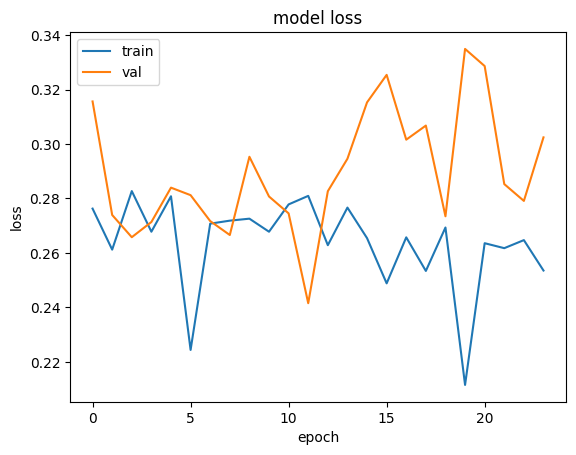

In [33]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
embeddings = model.layers[2].get_weights()[0]

In [35]:
most_similar('физика', embeddings)

['физика',
 'химия',
 'астрономия',
 'математика',
 'социология',
 'физиология',
 'биохимия',
 'биология',
 'языкознание',
 'квантовый']

In [36]:
most_similar('племя', embeddings)

['племя',
 'галльский',
 'гурон',
 'индеец',
 'тюркский',
 'индейский',
 'картли',
 'монгольский',
 'хана',
 'франкский']

## CBOW

In [37]:
## cbow
def gen_batches_cbow(sentences, window = 6, batch_size=2500):

    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [38]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(10,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=500)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=500)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
model.build([(None, 1), (None, 10)])

In [40]:
model.fit(gen_batches_cbow(sentences[:19000], window=10),
          validation_data=gen_batches_cbow(sentences[19000:],  window=10),
          batch_size=2500,
          steps_per_epoch=2000,
          validation_steps=32,
          epochs=24)

Epoch 1/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - accuracy: 0.8597 - loss: 0.3227 - val_accuracy: 0.9117 - val_loss: 0.2261
Epoch 2/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9164 - loss: 0.2091 - val_accuracy: 0.9227 - val_loss: 0.1945
Epoch 3/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9231 - loss: 0.1951 - val_accuracy: 0.9277 - val_loss: 0.1812
Epoch 4/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9370 - loss: 0.1596 - val_accuracy: 0.9182 - val_loss: 0.2109
Epoch 5/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9387 - loss: 0.1559 - val_accuracy: 0.9289 - val_loss: 0.1866
Epoch 6/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9449 - loss: 0.1415 - val_accuracy: 0.9202 - val_loss: 0.2229
Epoch 7/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9534 - loss: 0.1219 - val_accuracy: 0.9338 - val_loss: 0.1842
Epoch 8/24
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9546 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


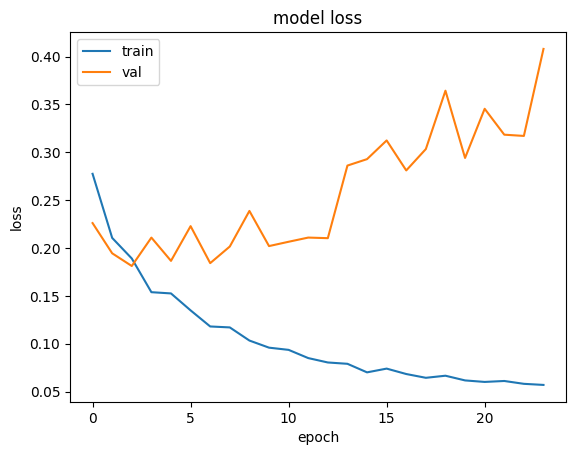

In [41]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
embeddings = model.layers[2].get_weights()[0]

In [ ]:
embeddings.shape

In [45]:
most_similar('физика', embeddings)

['физика',
 'математика',
 'биохимия',
 'химия',
 'астрономия',
 'квантовый',
 'биология',
 'РДС',
 'филология',
 'прикладной']

In [46]:
most_similar('племя', embeddings)

['племя',
 'индейский',
 'индеец',
 'римлянин',
 'тюрок',
 'беотийский',
 'племенной',
 'грузин',
 'тюркский',
 'скотовод']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [29]:
import gensim

In [53]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


In [56]:
texts = open("wiki_data.txt",  encoding="utf-8").read().split('\n')

texts = [preprocess(text) for text in texts]

In [57]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=500, 
                             min_count=20, 
                             max_vocab_size=1500000000,
                             window=6,
                             epochs=10,
                             hs=0,
                             negative=10,
                             sample=1e-5)

CPU times: user 2min 26s, sys: 775 ms, total: 2min 27s
Wall time: 52.1 s


In [58]:
w2v.wv.most_similar('племя')

[('означающего', 0.9779607653617859),
 ('древняя', 0.9740784168243408),
 ('исчезли', 0.9691495895385742),
 ('означающее', 0.9665851593017578),
 ('живших', 0.9664527773857117),
 ('регионом', 0.9660058617591858),
 ('обширные', 0.9652324318885803),
 ('датируются', 0.9638247489929199),
 ('викингов', 0.962053656578064),
 ('индейцы', 0.9612541794776917)]

In [59]:
%%time

ft = gensim.models.FastText(texts, min_n=3, max_n=9)

CPU times: user 6min 40s, sys: 738 ms, total: 6min 41s
Wall time: 2min 24s


In [60]:
ft.wv.most_similar('племя')

[('гремячье', 0.8365875482559204),
 ('бремя', 0.8261258006095886),
 ('тремя', 0.8126027584075928),
 ('вовремя', 0.790561854839325),
 ('«время', 0.7794679999351501),
 ('«имя', 0.7782532572746277),
 ('время', 0.7750895619392395),
 ('вр', 0.7700076699256897),
 ('время»', 0.7404011487960815),
 ('семя', 0.7402455806732178)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

In [61]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [62]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)


7231

In [66]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}


In [67]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [69]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [72]:
%pip install razdel

Note: you may need to restart the kernel to use updated packages.


In [73]:
from razdel import tokenize

In [74]:
gensim_w2v_a = gensim.models.Word2Vec(
    texts,
    vector_size=666,
    min_count=20,
    max_vocab_size=1000000000,
    window=9,
    epochs=10,                             
    hs=0,
    negative=15,
    sample=1e-4,
    sg=0  
)

In [75]:
def vectorize_text(tokens, wtv:gensim.models.Word2Vec):
    vectorized = []

    for token in tokens:
        try:
            vectorized.append(wtv.wv[token])
        except KeyError:
            continue 

    result = sum(vectorized)/len(vectorized)
    return result

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
len(X_train)

13691

In [89]:
X_vectors = [vectorize_text(c, gensim_w2v_a) for c in X_train]

In [90]:
len(X_vectors)

13691

In [91]:
X_vectors_test = [vectorize_text(c, gensim_w2v_a) for c in X_valid]

In [92]:
logreg = LogisticRegression()

In [93]:
logreg.fit(X_vectors, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [94]:
preds = logreg.predict(X_vectors_test)

In [87]:
from sklearn.metrics import classification_report

In [95]:
print(
    classification_report(
        y_valid,
        preds
    )
)

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80       475
         1.0       0.70      0.13      0.23       246

    accuracy                           0.69       721
   macro avg       0.69      0.55      0.51       721
weighted avg       0.69      0.69      0.61       721



# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.